In [1]:
from ad_netV2 import *
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Lambda,MaxPooling2D,Dropout,Conv2DTranspose,concatenate

2.0.0-alpha0


In [2]:
#from tf.keras import backend as K
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'input/stage1_train/'
TEST_PATH = 'input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
random.seed = 40
np.random.seed = 40

In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [00:59<00:00,  8.08it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 126.44it/s]

Done!


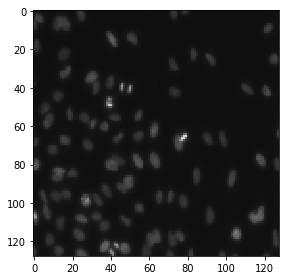

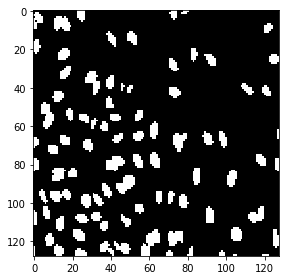

In [5]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [6]:
input_dimension=(128,128,3)
# lr=0.001

inputs = Input(input_dimension)
# s = Lambda(lambda x: x ) (inputs)
inblock_inp= inblock(inputs)
resblock_a=resblock_A(inblock_inp)
path3=Path_3(resblock_a)
    
#reduction_a=reduction_A(resblock_a)
reduction_a=tf.keras.layers.MaxPooling2D((2,2))(resblock_a)
resblock_b=resblock_B(reduction_a)
path4=Path_4(resblock_b)
    
reduction_b=tf.keras.layers.MaxPooling2D((2,2))(resblock_b)
resblock_c=resblock_C(reduction_b)
    
    
Up1=tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(resblock_c),path4],axis=3)
resblock_b1=resblock_B(Up1)
   
Up2=tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(resblock_b),path3],axis=3)
resblock_a1=resblock_A(Up2)
outblock=inblock(resblock_a1)

print("out",outblock.shape)    
conv_final=Conv2D(1,(1,1),activation='sigmoid',padding='same')(outblock)
print("conv final",conv_final.shape)   


model = tf.keras.Model(inputs=[inputs], outputs=[conv_final])
#model.compile(tf.optimizers.Adam(lr),loss = 'binary_crossentropy', metrics = ['accuracy'])

# model = tf.keras.utils.multi_gpu_model(model,gpus=2, cpu_merge=False)
# print("Training using multiple GPUs..")

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
print(model.summary())

Tensor("input_1:0", shape=(None, 128, 128, 3), dtype=float32)
inblock (None, 128, 128, 32)
resblock_a (None, 128, 128, 64)
path3 (None, 128, 128, 32)
resblock_B (None, 64, 64, 256)
path4 (None, 64, 64, 32)
resblock_c (None, 32, 32, 1024)
resblock_B (None, 64, 64, 256)
resblock_a (None, 128, 128, 64)
Tensor("batch_normalization_v2_10/cond/Identity:0", shape=(None, 128, 128, 64), dtype=float32)
inblock (None, 128, 128, 32)
out (None, 128, 128, 32)
conv final (None, 128, 128, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 6)  168         input_1[0][0]                    
_________

conv2d_40 (Conv2D)              (None, 128, 128, 64) 27712       conv2d_39[0][0]                  
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 128, 128, 128 0           conv2d_35[0][0]                  
                                                                 conv2d_37[0][0]                  
                                                                 conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 128, 128, 64) 6208        concatenate_6[0][0]              
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 128, 128, 64) 8256        concatenate_7[0][0]              
__________________________________________________________________________________________________
add_6 (Add

In [8]:

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5, mode='min', verbose=1)
cs = tf.keras.callbacks.ModelCheckpoint('test_3.h5',monitor='val_accuracy', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50,shuffle=True,steps_per_epoch=None,callbacks=[es,cs])

Train on 603 samples, validate on 67 samples
Epoch 1/50
592/603 [============================>.] - ETA: 0s - loss: 0.1104 - accuracy: 0.9675
Epoch 00001: val_accuracy improved from -inf to 0.96472, saving model to test_3.h5
603/603 [==============================] - 5s 9ms/sample - loss: 0.1101 - accuracy: 0.9676 - val_loss: 0.0966 - val_accuracy: 0.9647
Epoch 2/50
592/603 [============================>.] - ETA: 0s - loss: 0.1025 - accuracy: 0.9694
Epoch 00002: val_accuracy improved from 0.96472 to 0.96885, saving model to test_3.h5
603/603 [==============================] - 5s 8ms/sample - loss: 0.1026 - accuracy: 0.9693 - val_loss: 0.0843 - val_accuracy: 0.9689
Epoch 3/50
592/603 [============================>.] - ETA: 0s - loss: 0.0925 - accuracy: 0.9711
Epoch 00003: val_accuracy improved from 0.96885 to 0.97022, saving model to test_3.h5
603/603 [==============================] - 5s 8ms/sample - loss: 0.0925 - accuracy: 0.9710 - val_loss: 0.0825 - val_accuracy: 0.9702
Epoch 4/50
59

In [9]:
model = tf.keras.models.load_model('test_3.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 0s 8ms/sample


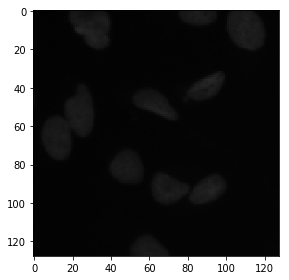

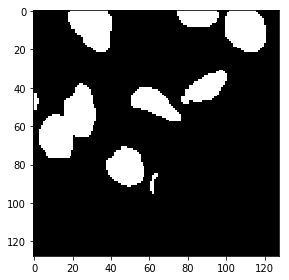

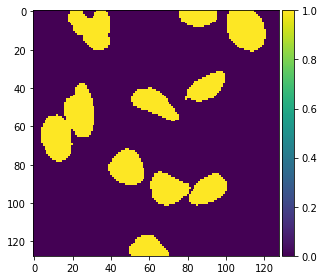

In [10]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

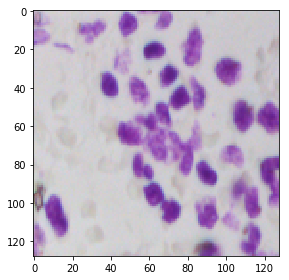

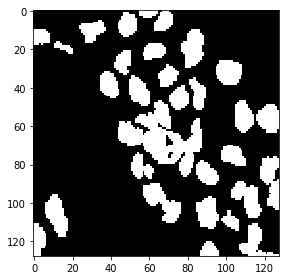

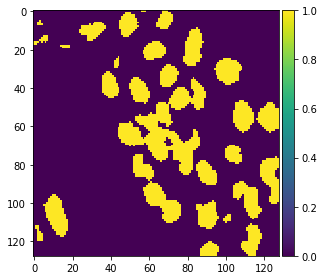

In [11]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()